In [14]:
library(tidyverse)
library(repr)
library(tidymodels)

In [15]:
data <- read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vSTyupJYW8-dOI7rTKOVE-bMT4M_8UnVnRLOJGavyVh33-4wHTkP4Q-uWX9mwMQul2kxMl8aJLR0FHB/pub?output=csv")

Parsed with column specification:
cols(
  .default = col_double(),
  url = col_character()
)

See spec(...) for full column specifications.



In [16]:


named_data <- data %>%
    rename(
        monday = weekday_is_monday,
        tuesday = weekday_is_tuesday,
        wednesday = weekday_is_wednesday,
        thursday = weekday_is_thursday,
        friday = weekday_is_friday,
        saturday = weekday_is_saturday,
        sunday = weekday_is_sunday,
        lifestyle = data_channel_is_lifestyle,
        entertainment =  data_channel_is_entertainment,
        business = data_channel_is_bus,
        social_media =  data_channel_is_socmed,
        technology =  data_channel_is_tech,
        world =  data_channel_is_world
    )


Genre,Day_Of_Week,shares,abs_pos_neg_ratio,global_subjectivity
<fct>,<fct>,<dbl>,<dbl>,<dbl>
entertainment,monday,593,3.606061,0.5216171
business,monday,711,6.644338,0.3412458
business,monday,1500,6.375000,0.7022222
entertainment,monday,1200,2.088008,0.4298497
technology,monday,505,11.490024,0.5135021
technology,monday,855,1.977800,0.4374086


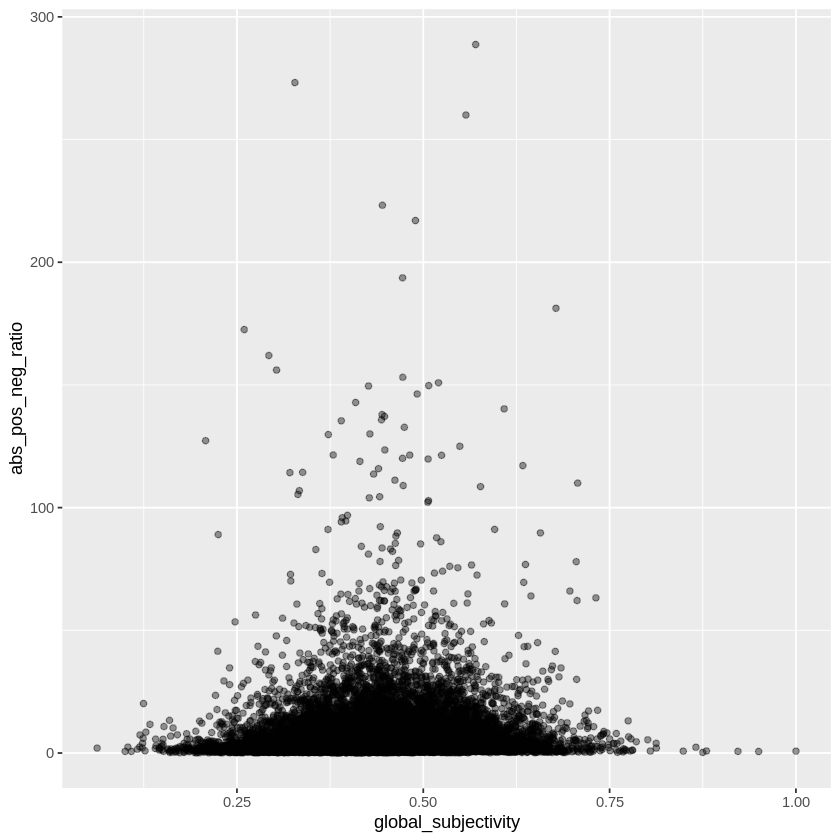

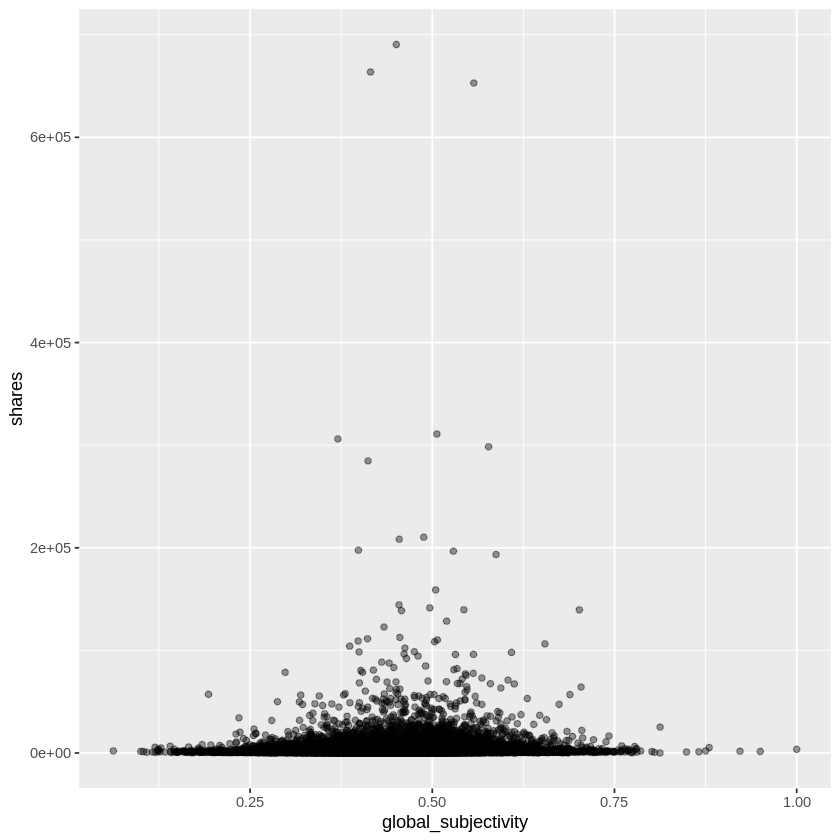

In [29]:
#It didn't work when all in one pipe, I have no idea why. This seems to work though
tidy_data <- named_data %>%
    pivot_longer(cols =  lifestyle:world, 
                 names_to = 'Genre', 
                 values_to = 'Genre_Present') %>%
    filter(Genre_Present == 1) %>%
    pivot_longer(cols =   monday:sunday, 
                 names_to = 'Day_Of_Week', 
                 values_to = 'Day_Present') %>%
    filter(Day_Present == 1) %>%
    filter(global_rate_positive_words != 0 & global_rate_negative_words != 0) %>%

    mutate(abs_pos_neg_ratio = (global_rate_positive_words*avg_positive_polarity)/abs(global_rate_negative_words*avg_negative_polarity)) %>%

    mutate(Genre = as_factor(Genre)) %>%
    mutate(Day_Of_Week = as_factor(Day_Of_Week)) %>%
    select(Genre, Day_Of_Week, shares, abs_pos_neg_ratio, global_subjectivity)

head(tidy_data)
share_plot <- ggplot(tidy_data, aes(x = global_subjectivity, y = abs_pos_neg_ratio)) +
  geom_point(alpha = 0.4)

share_plot3 <- ggplot(tidy_data, aes(x = global_subjectivity, y = shares)) +
  geom_point(alpha = 0.4) 
share_plot

share_plot3

In [30]:
set.seed(1234)
publishing_split <- initial_split(tidy_data, prop = 0.6, strata = shares)
publishing_train <- training(publishing_split)
publishing_test <- testing(publishing_split)

head(publishing_train)

day_table <- publishing_train %>%
    group_by(Day_Of_Week) %>%
    summarize(total_articles=n(), avg_shares=mean(shares),abs_pos_neg_ratio = mean(abs_pos_neg_ratio),global_subjectivity = mean(global_subjectivity))
day_table
#grouped by the day of the week so we can summarize the total amount of articles of that day of the week, the average shares of that day of the week, and the positive to negative word ratio of that day of the week

genre_table <- publishing_train %>%
    group_by(Genre) %>%
    summarize(total_articles=n(), avg_shares=mean(shares),abs_pos_neg_ratio = mean(abs_pos_neg_ratio),global_subjectivity = mean(global_subjectivity) )
genre_table

Genre,Day_Of_Week,shares,abs_pos_neg_ratio,global_subjectivity
<fct>,<fct>,<dbl>,<dbl>,<dbl>
entertainment,monday,593,3.606061,0.5216171
business,monday,711,6.644338,0.3412458
entertainment,monday,1200,2.088008,0.4298497
technology,monday,855,1.977800,0.4374086
technology,monday,891,9.748504,0.5434742
world,monday,710,1.611429,0.3138889


`summarise()` ungrouping output (override with `.groups` argument)



Day_Of_Week,total_articles,avg_shares,abs_pos_neg_ratio,global_subjectivity
<fct>,<int>,<dbl>,<dbl>,<dbl>
monday,3295,3369.657,5.527280,0.4466171
tuesday,3507,2792.080,5.669865,0.4455466
wednesday,3664,2879.380,5.576851,0.4460018
thursday,3517,2894.013,5.668340,0.4473297
friday,2732,2793.846,5.350205,0.4470399
saturday,1142,3364.944,6.424908,0.4525791
sunday,1251,3531.652,5.797623,0.4488189


`summarise()` ungrouping output (override with `.groups` argument)



Genre,total_articles,avg_shares,abs_pos_neg_ratio,global_subjectivity
<fct>,<int>,<dbl>,<dbl>,<dbl>
entertainment,4015,2974.835,4.900262,0.4656390
business,3541,3265.274,6.739769,0.4387305
technology,4146,3178.463,6.982449,0.4579006
lifestyle,1237,3771.733,6.353915,0.4798064
world,4799,2318.699,3.780453,0.4145643
social_media,1370,3678.478,6.701515,0.4646855


In [32]:
share_spec <- linear_reg() %>% 
       set_engine("lm") %>%
       set_mode("regression")



share_recipe <- recipe(shares ~ ., data = publishing_train) %>%
       step_scale(-shares, -Day_Of_Week, -Genre) %>%
       step_center(-shares, -Day_Of_Week, -Genre)



══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
         (Intercept)         Genrebusiness       Genretechnology  
             3220.44                470.55                288.90  
      Genrelifestyle            Genreworld     Genresocial_media  
              733.55               -405.47                766.57  
  Day_Of_Weektuesday  Day_Of_Weekwednesday   Day_Of_Weekthursday  
             -578.41               -495.67               -483.23  
   Day_Of_Weekfriday   Day_Of_Weeksaturday     Day_Of_Weeksunday  
             -554.62                -35.21                163.37  
   abs_pos_neg_ratio   global_subjectivity  
             -124.49  

`geom_smooth()` using formula 'y ~ x'



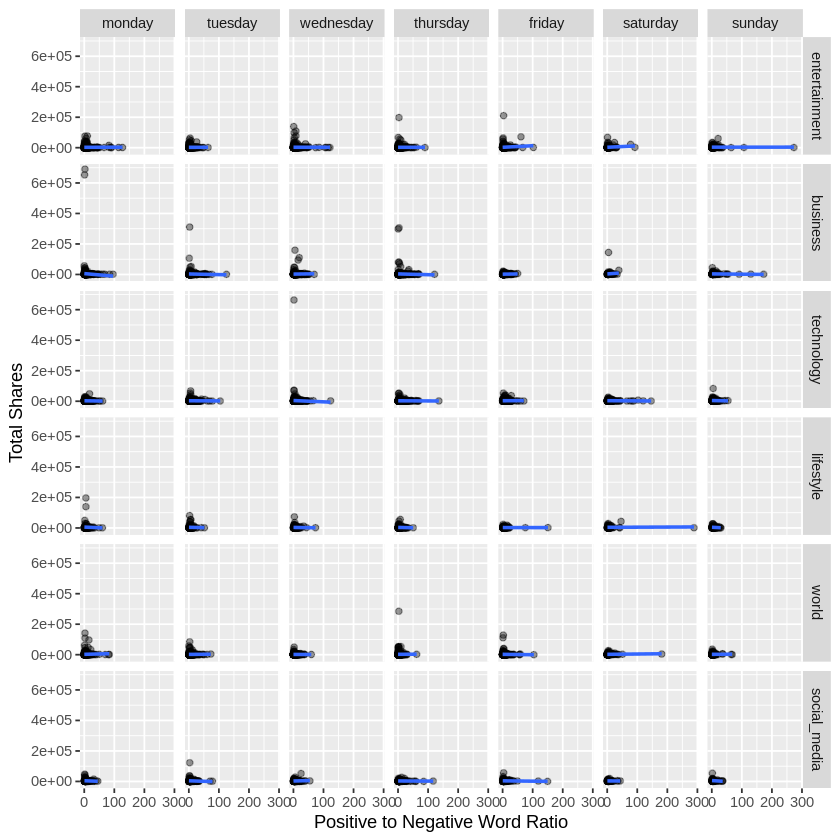

In [33]:


share_fit <- workflow() %>%
       add_recipe(share_recipe) %>%
       add_model(share_spec) %>%
       fit(publishing_train)

share_fit

share_plot_train <- ggplot(publishing_train, aes(x = abs_pos_neg_ratio, y = shares)) +
  geom_point(alpha = 0.4) +
  labs(x="Positive to Negative Word Ratio", y="Total Shares")+
  facet_grid(Genre ~ Day_Of_Week)+
  geom_smooth(method = "lm", se = FALSE)

share_plot_train

In [34]:
share_results <- share_fit %>%
         predict(publishing_test) %>%
         bind_cols(publishing_test) %>%
         metrics(truth = shares, estimate = .pred)

share_results
lm_rmspe <- share_results %>%
          filter(.metric == "rmse") %>%
          select(.estimate) %>%
          pull()


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,6.048353e+03
rsq,standard,9.739964e-03
mae,standard,2.459793e+03


In [35]:


options(repr.plot.width = 15, repr.plot.height = 15)





share_plot <- ggplot(publishing_test, aes(x = abs_pos_neg_ratio, y = shares)) +
  geom_point(alpha = 0.4) +
  labs(x="Positive to Negative Word Ratio", y="Total Shares")+
  facet_grid(Genre ~ Day_Of_Week)+
  geom_smooth(method = "lm", se = FALSE, data=publishing_train)

`geom_smooth()` using formula 'y ~ x'



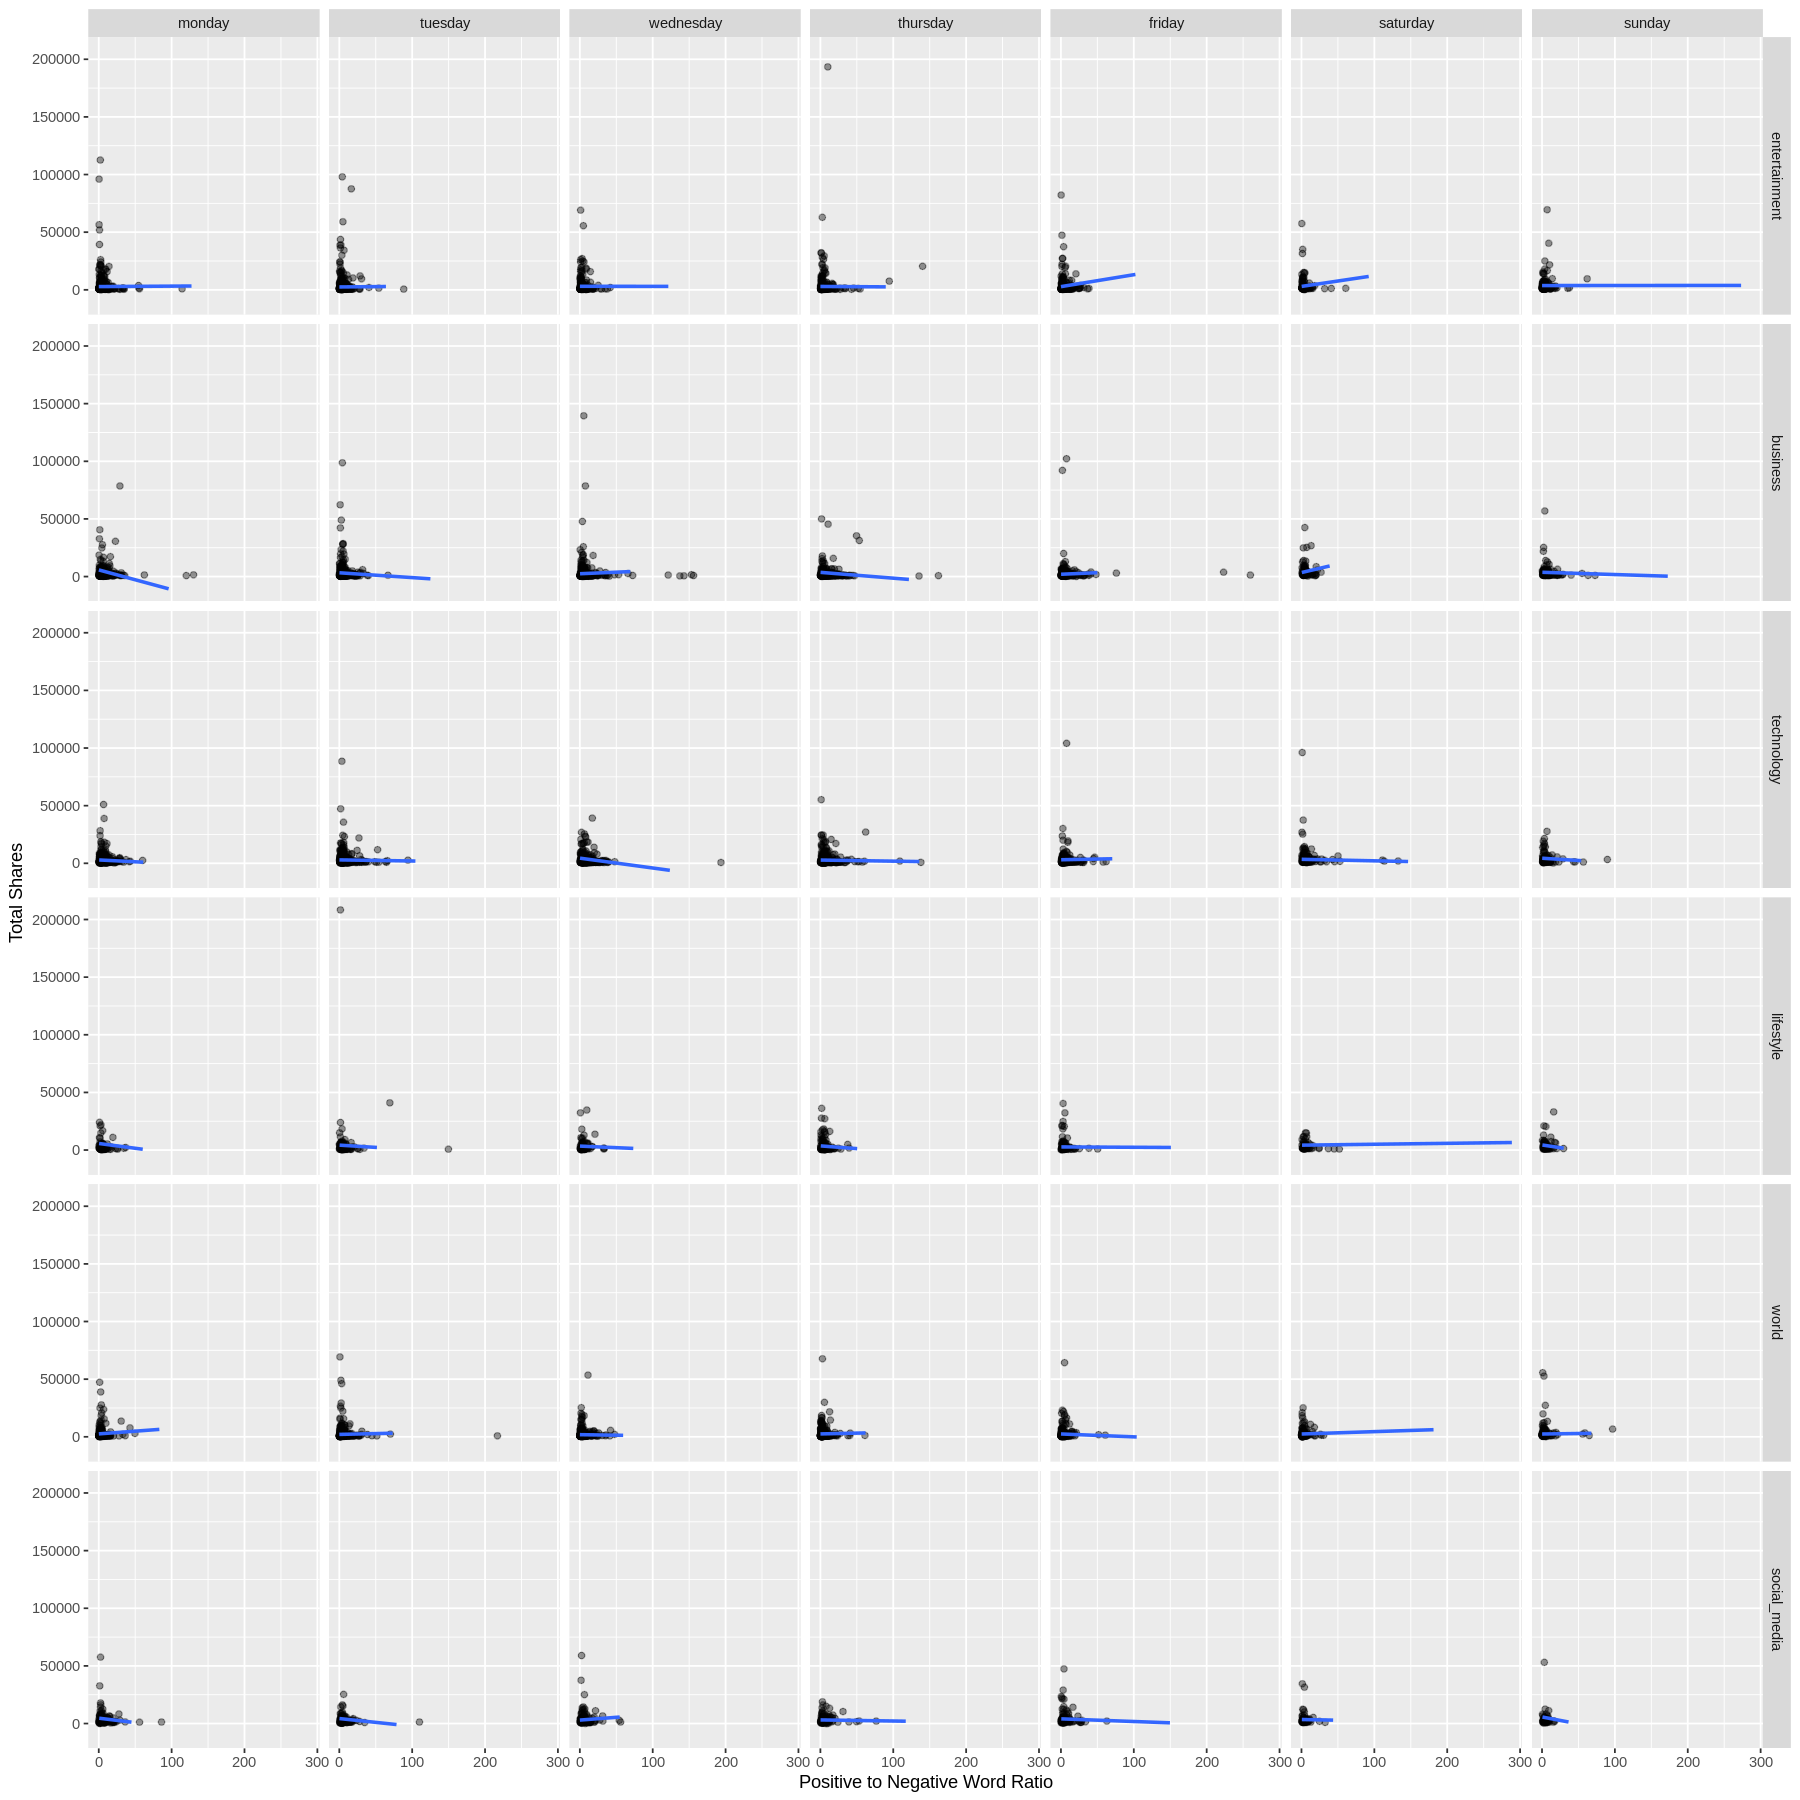

In [36]:
share_plot